In [577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

## Deep Learning For Portfolio Optimization
-------

Portfolio optimization deals with the process of choosing the "best" asset allocations to invest in, from a subset of stocks considered out of all possible universe of assets. It's main aim is to optimize a suitably chosen objective function, such as maximizing returns while minimizing the risk. The foundations of this theory, which is also known as the modern portfolio theory, was pioneered by Markowitz's influencial work [[1]](https://www.jstor.org/stable/2975974?seq=1). 

The main utility of constructing such a portfolio lies in the principle of diversification which tends to larger returns per a desired level of risk as compared to trading an individual asset. We can illustrate this in a simple example considering two stocks $A$ and $B$ assuming their returns follows a normal distribution: 

$$ \textrm{Stock A}:\quad R_A \sim \mathcal{N}(\mu_A, \sigma_A^2), \quad\quad \textrm{Stock B}:\quad R_B \sim \mathcal{N}(\mu_B, \sigma_B^2) $$

where $\mu_i, \sigma_i^2$ ($i = \{A,B\}$) are the expected returns and variance of each asset defined as: 

$$ \mathbb{E}[R_i] = \mu_i, \quad\quad \mathbb{V}[R_i] \equiv  \mathbb{E}[(R_i-\mu_i)^2]  = \sigma_i^2 .$$

Now consider the 2-asset portfolio returns: 

$$ R_p = w_A R_A + w_B R_B, $$

where $w_i \geq 0$ (long-only) is the fractional allocation of each asset subject to the condition $\sum_i w_i = 1$. By the linearity of the expectation values, the expected return of the portfolio is given by 

$$ \mathbb{E}[R_p] \equiv \mu_p = w_A \mu_A + w_B \mu_B \quad\quad\quad (1).$$

On the other hand the variance of the portfolio returns can be computed as 

$$ \mathbb{V}[R_p] = \mathbb{E}[(R_p-\mu_p)^2] \equiv \sigma_p^2 =  \mathbb{E}[(w_A (R_A -\mu_A)+ w_B (R_B - \mu_B))^2] = w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2 + 2 w_A w_B \Sigma_{AB}\quad\quad\quad (2),$$

where $\Sigma_{AB}$ is the covariance matrix of returns  

$$ \textrm{Cov}[R_A, R_B] = \mathbb{E}[(R_A - \mu_A)(R_B - \mu_B)] \equiv \Sigma_{AB} \quad\quad\quad (3)$$

which can be related to the correlation $\rho_{AB}$ of the assets as 

$$ \Sigma_{AB} = \sigma_A \sigma_B \rho_{AB} . $$ 

To illustrate our main point, we can consider completely uncorrelated assets $\rho_{AB = 0}$ with identical volatility $\sigma_A = \sigma_B = \sigma$ and mean returns $\mu_A = \mu_B = \mu$. In this case the expected return of the portfolio is identical to the case when we invest in only one of the assets, namely

$$ \mathbb{E}[R_p] \equiv \mu_p = (w_A + w_B)\mu = \mu \quad\quad\quad (4). $$

On the other hand the variance of portfolio returns reduces to 

$$ \mathbb{V}[R_p] = \mathbb{E}[(R_p-\mu_p)^2] = (w_A^2 + w_B^2)\, \sigma^2 = (1 - 2 w_A w_B)\, \sigma^2  \quad\quad\quad (5),$$

where in the last equality we utilized the constraint $w_A + w_B = 1 \to w_A^2 + w_B^2 + 2 w_A w_B = 1$. It is clear from eqs. (4) and (5) that as long as we allocate non-zero weights to each asset $w_{A/B} > 0$ (i.e diversify our investments) the risk associated for returns of the portfolio will be reduced while providing as good returns as investing only a single asset. 

The power of such a diversification is notwithstanding, it is not straightforward to select the optimal asset allocations in a portfolio as the dynamics of financial markets change over time. For example assets that exhibit strong negative correlations ($\rho_{AB} < 0$) (see eqs. (2) and (3)) in the past may become positively correlated in the future. Such a situation would add extra risk to the initial portfolio chosen, degrading its performance. 

### Typical Tasks of Portfolio Optimization:
----

Classical approaches (such as MPT [[1]](https://www.jstor.org/stable/2975974?seq=1)) adopt a two step strategy: 

1. Predict the expected returns and covariance matrix
2. Solve a constrained optimization proglem (e.g using linear or Quadratic programming methods) to derive the optimal weights given these predictions. 

However, predicting the financial returns in step 1 is extremely difficult as they are highly stochastic with low signal to noise ratio. In turn, deriving predictive signals and the generalization/robustness of these signals are questionable. On the other hand, a second challange associated with the standard Mean-Variance optimization methods (such as MPT)is the estimation of the covariance matrix especially when the considered asset universe is large [[2]](http://www.ledoit.net/honey.pdf). Furthermore, diffuculties of predicting returns notwithstanding, it has been showed that this method is not guaranteed to maximise the performence of a portfolio, as the prediction steps attempt to minimise a prediction loss which is not the overall reward from the portfolio (see. eg [[3]](https://www.iro.umontreal.ca/~lisa/pointeurs/profitcost.pdf)). 

Such a standard measure of a portfolio's reward is the Sharpe Ratio [[4]](https://web.stanford.edu/~wfsharpe/art/sr/sr.htm) which describes the expected return of a portfolio per unit risk: 


$$ \textrm{Sharpe} = \frac{\mathbb{E}[R_p]}{\sqrt{\mathbb{V}[R_p]}} \equiv  \frac{\mu_p}{\sigma_p} $$

### A direct approach to portfolio Optimization
------

Motivated by the shortcomings of a standard 2 step approach of portfolio optimization, here we would like follow the recent work [[5]](https://arxiv.org/abs/2005.13665) that aims to maximise the (future) sharpe ratio given the current market conditions, utilizing a Deep Neural Network. In this approach, the forecasting step is avoided by connecting multiple features to extract the essential information on the current market conditions using a neural network that outputs portfolio weights in order to maximize the Sharpe Ratio. 

### Data Under Consideration
------
In [[5]](https://arxiv.org/abs/2005.13665), exchange traded funds (ETFs) of market indices are used to form a portfolio, instead of focusing individual assets particularly due to their small (and even negative) correlations. Four market indices are used: US total stock index (`VTI`), US agregate bond index (`AGG`), US commodity index (`DBC`) and volatility index (`VIX`) which are popularly traded ETFs due to their high liquidity and small expense ratios. 



In [585]:
import yfinance as yf

start = '2006-02-06' #DBC starts at 6 feb 2006
end ='2024-07-02'

#Bond,Commodities,Stocks,
etfs = ['AGG', 'DBC', 'VTI']
etfs_df = pd.DataFrame()

for etf in etfs:

   etfs_df[etf] = yf.Ticker(etf).history(start=start,end=end)['Close']

# Add volatility seperately using to_numpy() as it does not work for some reason, 
vol_ticker = '^VIX'

etfs_df[vol_ticker] = yf.Ticker(vol_ticker).history(start=start,end=end)['Close'].to_numpy()

In [586]:
etfs_df.isna().sum()

AGG     0
DBC     0
VTI     0
^VIX    0
dtype: int64

In [587]:
# hour-stamps are unneccesary 
etfs_df.head()

AGG        DBC        VTI   ^VIX
Date                                                             
2006-02-06 00:00:00-05:00  57.001484  20.889500  44.792027  13.04
2006-02-07 00:00:00-05:00  56.961632  20.285257  44.355915  13.59
2006-02-08 00:00:00-05:00  56.933193  20.198935  44.675026  12.83
2006-02-09 00:00:00-05:00  56.967335  20.388840  44.589931  13.12
2006-02-10 00:00:00-05:00  56.847893  20.017662  44.682114  12.87

In [588]:
# remove hour stamps as the data has daily frequency

etfs_df.reset_index(inplace = True)

etfs_df['Date'] = etfs_df['Date'].dt.date

etfs_df.set_index('Date', inplace=True)

In [134]:
# Save the data to a csv

etfs_df.to_csv('ETFs.csv')

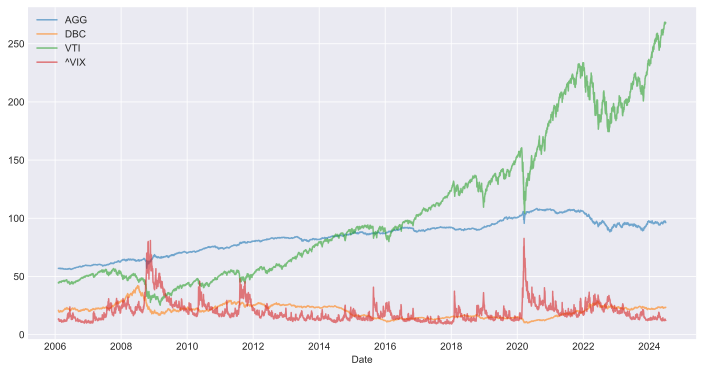

In [590]:
fig, axes = plt.subplots(figsize = (12,6))

etfs_df.plot(ax = axes, alpha = 0.6)

axes.grid()

In [591]:
# global correlations show that some indexes are negatively correlated but this is stock prices 

etfs_df.corr()

AGG       DBC       VTI      ^VIX
AGG   1.000000 -0.525890  0.811631 -0.110436
DBC  -0.525890  1.000000 -0.266982  0.066364
VTI   0.811631 -0.266982  1.000000 -0.146255
^VIX -0.110436  0.066364 -0.146255  1.000000

In [592]:
import itertools as it 

# helper function for pairwise correlations for a chosen rolling window 
def pairwise_corr(data, window):
    
    tuple_pairs_list = list(it.combinations(etfs_df.columns, 2))
    
    corr_ts = pd.DataFrame()
    
    for pair in tuple_pairs_list:
        
        pair = list(pair)
        
        corr_ts[pair[0]+'&'+pair[1]] = data[pair].rolling(window).corr().dropna(axis = 0).iloc[0::2][[pair[1]]].droplevel(1, axis = 0)
        
    return corr_ts

In [593]:
# The resulting heatmap of return correlations  

fig, axes = plt.subplots(figsize = (15,5))

sns.heatmap(pairwise_corr(etfs_df.pct_change().fillna(0), 50).transpose(), ax = axes)


<Axes: xlabel='Date'>

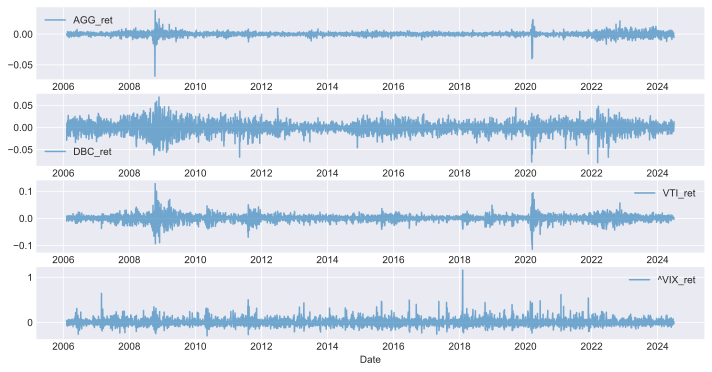

In [594]:
# returns  

etf_returns_df = etfs_df.pct_change().dropna(axis = 0) # drop the first value 

etf_returns_df.columns = etfs_df.columns + '_ret'

fig, axes = plt.subplots(4,1, figsize = (12,6))

for idx, col in enumerate(etf_returns_df.columns):
    
    etf_returns_df[col].plot(ax = axes[idx], alpha = 0.6, label = col)

    axes[idx].grid()
    axes[idx].legend()
    

We observe the usualy volatility clustering for all assets. This is especially visible for Bonds, Commidities and Stocks around the 2008 financial crisis and Covid-19 crisis. Extreme values for each asset is also visible, e.g especially for Bonds!

The objective of the deep learning approach we focus is to optimize the sharpe ratio of future portfolio's by outputting the weights as decision variables based on past market behavior. Since the sharpe ratio computation assumes that the returns are Normally distributed, we may benefit from normalizing the data (later). 

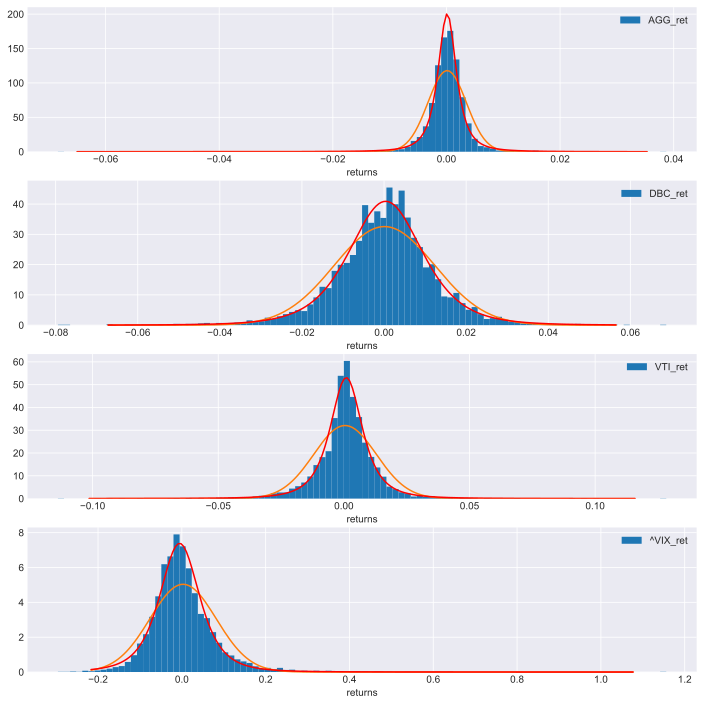

In [596]:
from scipy.stats import norm, t

fig, axes = plt.subplots(4,1,figsize = (12,12))

for idx, col in enumerate(etf_returns_df.columns): 
    
    return_range = np.linspace(etf_returns_df[col].min() + etf_returns_df[col].std(), etf_returns_df[col].max() - etf_returns_df[col].std(), 200)
    
    dof, loc, scale = t.fit(etf_returns_df[col]) # fit a t-distribution, degrees of freedom (dof), mean location (loc), and std (scale) 
    
    tpdf_list = t.pdf(return_range, dof, loc, scale)
    normal_pdf = norm.pdf(return_range, loc = etf_returns_df[col].mean(), scale = etf_returns_df[col].std())
    

    etf_returns_df[col].hist(bins = 100, density = True, ax = axes[idx], label = col)
    
    axes[idx].plot(return_range, normal_pdf)
    axes[idx].plot(return_range, tpdf_list, c = 'red')

    axes[idx].set_xlabel('returns')
    axes[idx].legend()

As expected returns have fat tails and skinny shoulders with respect tot he Gaussian distribution. In fact a t-distribution fits much better to returns!

In [597]:
# mean and std of returns 

for col in etf_returns_df.columns:
    
    print(f"Mean and std of {col}: {np.mean(etf_returns_df[col]):.6f}, {np.std(etf_returns_df[col]):.6f}")

Mean and std of AGG_ret: 0.000119, 0.003381
Mean and std of DBC_ret: 0.000101, 0.012249
Mean and std of VTI_ret: 0.000464, 0.012439
Mean and std of ^VIX_ret: 0.002892, 0.079198


As we confirmed earlier from the explicit plots, `VIX` has the most volitile daily returns and `AGG` has the least on average. Average returns of all assets are positive. 

In [598]:
from scipy.stats import kurtosis, skew
# skewness and kurtosis of each series 

for col in etf_returns_df.columns:
    
    print(f"Skewness and kurtosis of {col}: {skew(etf_returns_df[col]):.4f}, {kurtosis(etf_returns_df[col]):.4f}")

Skewness and kurtosis of AGG_ret: -1.9756, 52.6571
Skewness and kurtosis of DBC_ret: -0.4015, 3.1117
Skewness and kurtosis of VTI_ret: -0.2178, 11.8092
Skewness and kurtosis of ^VIX_ret: 2.0506, 15.7953


We see that all the returns of all the assets except `^VIX` are left skewed which implies that the latter have a tail along positive returns. The excess kurtosis for all assests also imply how heavy the tails are with respect to a Gaussian distribution where kurtosis = 3. This implies, all assets have very unusual values, in particular the Bonds `AGG`, volatility index `^VIX` and `VTI` stocks index

In [599]:
# kolmogrow-Smirnow test (t-test)

from scipy.stats import t, kstest

for col in etf_returns_df.columns:

    returns = etf_returns_df[col].to_numpy()

    dof, loc, scale = t.fit(returns)

    KS_res = kstest(returns, lambda x: t.cdf(x,dof,loc,scale))

    print(f"t-test statistic for {col} using Kolmogrow-Smirnow: {KS_res.statistic:.4f} and p-val: {KS_res.pvalue:.4f}")

t-test statistic for AGG_ret using Kolmogrow-Smirnow: 0.0259 and p-val: 0.0040
t-test statistic for DBC_ret using Kolmogrow-Smirnow: 0.0152 and p-val: 0.2304
t-test statistic for VTI_ret using Kolmogrow-Smirnow: 0.0201 and p-val: 0.0471
t-test statistic for ^VIX_ret using Kolmogrow-Smirnow: 0.0272 and p-val: 0.0021


Although we have seen earlier that returns are definetely not normally distributed and t-dist seems to fit better, we can also reject the null hypothesis $H_0$ for the t-statistic: returns are t-distributed for all except  `DBC` (commodities). 

In [600]:
full_df = pd.concat([etf_returns_df,etfs_df[1:]], axis = 1)

full_df.index.name = None

full_df.index = pd.to_datetime(full_df.index)

### Establishing Baselines
-----

Before we move on the actual DL approach to portfolio optimization, we should establish some baseline algorithms that we can later compare with the DL approach. For this purpose we will setup the reallocation strategies, as well as the standard mean-variance (MV) optimisation and maximum diversification (MD) [[6]](https://www.tandfonline.com/doi/epdf/10.1080/23322039.2018.1427533?needAccess=true) strategies mentioned in [[5]](https://arxiv.org/abs/2005.13665). 

- Reallocation strategies: These strategies assume a fixed allocation ratio to relevant assets and rebalance the portfolios annually to maintain these ratios. We consider 4 different such strategies

    1. $\vec{w}_1 = [0.25\, \textrm{shares}, 0.25\, \textrm{bonds}, 0.25\, \textrm{commodities}, 0.25\, \textrm{volatility index}]$
    2. $\vec{w}_2 = [0.50\, \textrm{shares}, 0.10\, \textrm{bonds}, 0.20\, \textrm{commodities}, 0.20\, \textrm{volatility index}]$
    3. $\vec{w}_3 = [0.10\, \textrm{shares}, 0.50\, \textrm{bonds}, 0.20\, \textrm{commodities}, 0.20\, \textrm{volatility index}]$
    4. $\vec{w}_4 = [0.40\, \textrm{shares}, 0.40\, \textrm{bonds}, 0.10\, \textrm{commodities}, 0.10\, \textrm{volatility index}]$

    In general, portfolio weighted more on equities (`VTI`) would deliver better performance at the expense of larger volatility. 

- In the second set of baseline algorithms, we use the standard mean-variance (MV) method and the maximum Diversification (MD). For this purpose we use moving averages with a rolling window of 50 days to estimate the expected returns and covariance matrix. The portfolio weights are updated at a daily basis, and for example for MV we select weights that maximize Sharpe ratio for MV. 


To test the performence of baseline strategies (and our model later), we pick the testing period from 2011 to the end of April 2020 as in [[5]](https://arxiv.org/abs/2005.13665).


In [650]:
test_begin = '2011-01-03'
test_end = '2020-04-30'

test_df = full_df.loc[test_begin:test_end]

p_cols = test_df.columns[-4:]
ret_cols = test_df.columns[:4]

When reporting test performance, we include transaction costs without using volatility scaling, the modified portfolio return at time $t$ that takes into account these is given by [[7]](https://arxiv.org/abs/2111.09170)

$$ R_{p,t} = \sum_{i}^{D} (w_{i,t-1}\, r_{i,t} \, - \, C \cdot |w_{i,t}(1 + w_{i,t-1} r_{i,t}) - w_{i,t-1}|) \equiv \sum_{i}^{D} \tilde{R}_{i,t}, $$

where $w_{i,t-1}$ is the allocation estimates made at time $t-1$ for the trading period at time $t$, $D$ is the number of assets considered ($D = 4$ in our case) and $C$ is the cost rate in terms of basis points ($1\,\textrm{bp} = 10^{-4}$). The return of an instrument at time $t$ is denoted as 

$$ r_{i,t} = \frac{p_{i,t}}{p_{i,t_1}} - 1$$

where $p_{i,t}$ is the price of the asset $i$ at time $t$. 

We will report the following metrics on $R_p$ to evaluate the performance of all the methods we utilize:

- $\mathbb{E}[R_p]$: annualized expected return.
- $\sqrt{\mathbb{V}[R_p]}$ : annualized standard deviation or volatility.
- $\textrm{Sharpe}$: annualized Sharpe Ratio.
- ${\rm DD}(R_p)$: annualized downside deviation where only standard deviations of negative returns is calculated (a measure of downside risk).
- $\textrm{MDD}$: maximum drawdown.
- $\%\, \textrm{of} +\textrm{Ret}$: the ratio between positive and negative portfolio returns. 

These metrics will be calcuted according to the expressions below 

- Annualized expected portfolio returns:  $ K \cdot \mathbb{E}[R_p]$ where $K$ denotes the number of trading periods in a year. In general, this metric is introduced to provide a fair comparison of the results from strategies that operate with timeseries of different frequencies or investment periods of different lengths. For us we use daily data so that $K = 252$. 
- Annualized volatility of portfolio returns: $\sqrt{K \cdot \mathbb{V}[R_p]}$ 
- Annuzalized Sharpe ratio: 

$$ \sqrt{K} \frac{\mathbb{E}[R_p] - r_f}{\sqrt{\mathbb{V}[R_p]}} $$

where $r_f$ is the risk free rate which we take to be $r_f = 0$ for simplicity. 
- Annualized downside deviation: $\sqrt {K} \sqrt{\mathbb{V}[R^{<0}_p]}$
- Maximum  drawdown: 

    - Denoting the cumulative portfolio return at time $t$ as $\textrm{CR}_p(t)$. The drawdown at time $t$ is defined as 

        $$ \textrm{DD}(t) = \frac{\textrm{HWM}(t) - \textrm{CR}_p(t)}{\textrm{HWM}(t) }$$

        where the High Water Mark (HWM) is given by 

        $$ \textrm{HWM}(t) = \textrm{max}_{1\leq\tau\leq t}\,\, \textrm{CR}_p(t) $$

        we can then define the maximum drawdown over an investment period of length $T$ as 

        $$ \textrm{MDD}  =  \textrm{max}_{1\leq t\leq T}\,\, \textrm{DD}(t)$$

In [784]:

def rebalance_portfolio(daily_returns_df, initial_investment, weights, transaction_cost_rate):
    
    # Initial investment distribution
     
    investments = initial_investment * np.array(weights)
    
    # Initialize lists to store portfolio value, returns, cumulative returns
    portfolio_value = [initial_investment]
    portfolio_returns = []
    cumulative_returns = []  
    
    # Simulation loop
    for i in range(1, len(daily_returns_df)): # skip the first day index (i = 0)
        
        # daily returns of assets and the corresponding portfolio return
        
        daily_returns = daily_returns_df.iloc[i].values
        portfolio_return = np.dot(investments / np.sum(investments), daily_returns)
        portfolio_returns.append(portfolio_return)
        
        # Update portfolio value using cumulative return formula
        new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
        portfolio_value.append(new_portfolio_value)
        
        # Calculate cumulative return at that day and append
        cumulative_return = (new_portfolio_value / initial_investment)
        cumulative_returns.append(cumulative_return)
        
        # if the year of the index i is different than the year of the previous index do 
        if daily_returns_df.index[i].year != daily_returns_df.index[i-1].year:
            
                      
            # new year investment amounts for each asset (updated as we go through dataset)
            current_investments = new_portfolio_value * np.array(weights)
            
            # compute the transaction costs arise and update the new_portfolio_value accordingly
            
            transaction_costs = np.sum(np.abs(current_investments - investments))  * transaction_cost_rate
            new_portfolio_value -= transaction_costs
            
            # update investments variable that is used in the loop above
            investments = current_investments
            
            # assing the rebalanced portfolio value as the last portfolio value (to be used in the loop)
            portfolio_value[-1] = new_portfolio_value
            cumulative_returns[-1] = (new_portfolio_value / initial_investment) 

    # Convert to DataFrame for analysis
    portfolio_df = pd.DataFrame({
        'Date': daily_returns_df.index[1:],  # Exclude the initial date
        'Portfolio_Value': portfolio_value[1:],  # Exclude the initial value
        'Return': portfolio_returns,
        'Cumulative_Return': cumulative_returns
    })

    portfolio_df.set_index('Date', inplace=True)
    
    return portfolio_df


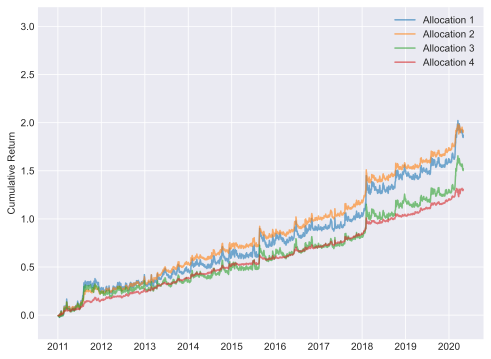

In [788]:
initial_investment = 10000

test_allocations = [[0.25] * 4, [0.10, 0.20, 0.50, 0.20], [0.50, 0.20, 0.10, 0.20], [0.40, 0.10, 0.40, 0.10]]
transaction_cost_rate = 0.0001

# Plot portfolio value and cumulative returns
fig, axes = plt.subplots(figsize = (8,6))

for idx, alloc in enumerate(test_allocations):
    
    portfolio_df = rebalance_portfolio(test_df[ret_cols], initial_investment, alloc, transaction_cost_rate)

    axes.set_ylabel('Cumulative Return')
    axes.plot(portfolio_df.index, np.log(portfolio_df['Cumulative_Return']), alpha = 0.6, label=f'Allocation {idx + 1}')

axes.set_ylim(-0.25,3.2)    
axes.legend()
axes.grid()

In [796]:
rolling_df_ret = test_df[ret_cols].rolling(50).mean().dropna()

In [797]:
rolling_df_ret

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
2011-03-15  0.000113  0.000730  0.000474  0.008779
2011-03-16  0.000192  0.000763 -0.000079  0.013115
2011-03-17  0.000173  0.001651  0.000190  0.011315
2011-03-18  0.000262  0.001554  0.000174  0.010265
2011-03-21  0.000211  0.001916  0.000534  0.006684
...              ...       ...       ...       ...
2020-04-24  0.000714 -0.006032 -0.002829  0.029760
2020-04-27  0.000608 -0.006419 -0.002466  0.027694
2020-04-28  0.000666 -0.006386 -0.002561  0.028526
2020-04-29  0.000653 -0.006175 -0.001948  0.025451
2020-04-30  0.000614 -0.005991 -0.002310  0.027928

[2298 rows x 4 columns]

In [804]:
test_df[ret_cols].rolling(50).cov().dropna().loc['2011-03-15']

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
AGG_ret   0.000005 -0.000003 -0.000007  0.000056
DBC_ret  -0.000003  0.000121  0.000018 -0.000102
VTI_ret  -0.000007  0.000018  0.000071 -0.000546
^VIX_ret  0.000056 -0.000102 -0.000546  0.005406

In [809]:
((10 * 1100) + (5 * 1400)) / 35.75

503.4965034965035

In [813]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

In [824]:
mu = expected_returns.mean_historical_return(test_df[ret_cols], compounding = False, returns_data = True) / 252

mu

AGG_ret     0.000150
DBC_ret    -0.000332
VTI_ret     0.000482
^VIX_ret    0.003571
dtype: float64

In [817]:
test_df[ret_cols].mean()

AGG_ret     0.000150
DBC_ret    -0.000332
VTI_ret     0.000482
^VIX_ret    0.003571
dtype: float64

In [825]:
cov = risk_models.sample_cov(test_df[ret_cols], returns_data = True) / 252

cov 

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
AGG_ret   0.000007 -0.000001 -0.000003  0.000028
DBC_ret  -0.000001  0.000100  0.000049 -0.000300
VTI_ret  -0.000003  0.000049  0.000120 -0.000690
^VIX_ret  0.000028 -0.000300 -0.000690  0.007216

In [826]:
test_df[ret_cols].cov()

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
AGG_ret   0.000007 -0.000001 -0.000003  0.000028
DBC_ret  -0.000001  0.000100  0.000049 -0.000300
VTI_ret  -0.000003  0.000049  0.000120 -0.000690
^VIX_ret  0.000028 -0.000300 -0.000690  0.007216

In [833]:
ef = EfficientFrontier(mu, cov, weight_bounds=(0,1))

weigths = ef.max_sharpe(risk_free_rate=0.)

In [834]:
weigths

OrderedDict([('AGG_ret', 0.5543625175456498),
             ('DBC_ret', 1.25e-14),
             ('VTI_ret', 0.396886168818632),
             ('^VIX_ret', 0.0487513136357009)])

In [1003]:

# rolling averages that serves as a estimate for the expected return and covariance matrix 

rolling_ret = test_df[ret_cols].rolling(50).mean().dropna()
rolling_cov = test_df[ret_cols].rolling(50).cov().dropna()

trading_days = rolling_ret.index

transaction_cost_rate = 0.0001


w_df = pd.DataFrame(index = rolling_ret.index)


for date, returns in rolling_ret.iterrows():
    
    date = date.strftime('%Y-%m-%d')
    
    # covariance matrix estimation for the day
    cov = rolling_cov.loc[date]
    ef = EfficientFrontier(returns * 100 , cov * 252 , weight_bounds=[0.01,1.], verbose = False)
    weights = ef.max_sharpe(risk_free_rate = 0)
    cleaned_weights = ef.clean_weights()
    
    for key, item in cleaned_weights.items():
    
        w_df.loc[date, f'{key}_w'] = item
               
transaction_costs = np.abs(w_df.diff(1).fillna(0)).sum(axis = 1) * transaction_cost_rate

# non-adjusted portfolio returns series object
na_port_ret = pd.DataFrame(test_df[ret_cols].loc[trading_days].values * w_df.values, index = trading_days).sum(axis = 1)

port_ret = na_port_ret - transaction_costs

cum_port_ret = (1+port_ret).cumprod()

<Axes: >

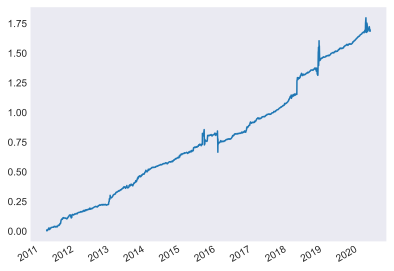

In [1004]:
np.log(cum_port_ret).plot()

In [1002]:
w_df.sum(axis = 1)

2011-03-15    1.00001
2011-03-16    1.00000
2011-03-17    1.00000
2011-03-18    1.00000
2011-03-21    0.99999
               ...   
2020-04-24    1.00000
2020-04-27    1.00000
2020-04-28    1.00000
2020-04-29    1.00000
2020-04-30    1.00000
Length: 2298, dtype: float64

In [1007]:
port_ret.mean() * 252

0.19672165799369717

In [1134]:
from scipy.optimize import minimize

def sharpe_ratio(w, mu, cov_matrix): # assume risk free rate to be zero 

    mean = w.dot(mu)
    std = np.sqrt(w.dot(cov_matrix).dot(w))
    return -(mean)/std  # negate so that we maximize

# Initial guess (equal distribution)
initial_guess = [0.25] * 4
bounds = [(0.01,0.5), (0.01, 0.25), (0.01,0.5), (0.01,0.25)] # put at least 0.01 percent to an asset so that we have a full portolio 

def weight_constraint(w):

    return w.sum() - 1

# Function to get optimal weights for a given window
def get_optimal_weights(mu, cov_matrix):
    
    optimized_result = minimize(sharpe_ratio, initial_guess, args=(mu,cov_matrix,), 
                                method='SLSQP', constraints = {'type': 'eq', 'fun': weight_constraint}, bounds=bounds)
    return optimized_result.x




In [1037]:
example_tday = rolling_ret.index[0].strftime('%Y-%m-%d')
example_tday

'2011-03-15'

In [1041]:
rolling_ret.loc[example_tday].values * 252

array([0.02840531, 0.18408597, 0.11934962, 2.21237238])

In [1042]:
rolling_cov.loc[example_tday].to_numpy() * 252

array([[ 1.32493243e-03, -6.99610158e-04, -1.82647600e-03,
         1.40644605e-02],
       [-6.99610158e-04,  3.03940420e-02,  4.53620996e-03,
        -2.55825325e-02],
       [-1.82647600e-03,  4.53620996e-03,  1.78384079e-02,
        -1.37638604e-01],
       [ 1.40644605e-02, -2.55825325e-02, -1.37638604e-01,
         1.36237629e+00]])

In [1052]:
get_optimal_weights(rolling_ret.loc[example_tday].values, rolling_cov.loc[example_tday].to_numpy())

array([0.26237714, 0.01577795, 0.64719495, 0.07464996])

In [1140]:

rolling_ret = test_df[ret_cols].rolling(50).mean().dropna()
rolling_cov = test_df[ret_cols].rolling(50).cov().dropna()

In [1141]:
# Initialize a DataFrame to store weights
weights_df = pd.DataFrame(index=rolling_ret.index, columns=rolling_ret.columns)

for date, returns in rolling_ret.iterrows():
    
    date = date.strftime('%Y-%m-%d')
    
    returns = rolling_ret.loc[date].values
    
    # covariance matrix estimation for the day
    cov = rolling_cov.loc[date].to_numpy()
    
    optimal_weights = get_optimal_weights(returns, cov)
    
    weights_df.loc[date] = optimal_weights

/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [1142]:
weights_df

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
2011-03-15  0.415696  0.027553       0.5  0.056751
2011-03-16  0.411771  0.029438       0.5  0.058791
2011-03-17  0.373614  0.068952       0.5  0.057434
2011-03-18  0.381871  0.062158       0.5  0.055971
2011-03-21  0.367287  0.080277       0.5  0.052436
...              ...       ...       ...       ...
2020-04-24       0.5      0.01  0.309685  0.180315
2020-04-27       0.5      0.01   0.31184   0.17816
2020-04-28       0.5      0.01  0.312213  0.177787
2020-04-29       0.5      0.01  0.320052  0.169948
2020-04-30  0.483796      0.01  0.328007  0.178197

[2298 rows x 4 columns]

In [1143]:
# non-adjusted portfolio returns series object
na_port_retn = (test_df[ret_cols].loc[rolling_ret.index]  * weights_df).sum(axis = 1)

transaction_costs = np.abs(weights_df.diff(1).fillna(0)).sum(axis = 1) * 0.0001

port_ret = na_port_retn - transaction_costs

cum_port_retn = (1+port_ret).cumprod()

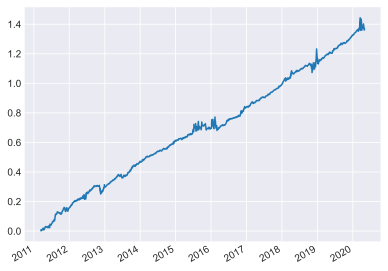

In [1144]:
np.log(cum_port_retn).plot()

plt.grid()

In [1095]:
rolling_prices = test_df[p_cols].rolling(50).mean().dropna()

In [1097]:
rolling_returns = rolling_prices.pct_change().fillna(0)

rolling_returns

AGG       DBC       VTI      ^VIX
2011-03-15  0.000000  0.000000  0.000000  0.000000
2011-03-16  0.000191  0.000691 -0.000113  0.013028
2011-03-17  0.000172  0.001570  0.000149  0.009806
2011-03-18  0.000261  0.001484  0.000134  0.008015
2011-03-21  0.000209  0.001836  0.000487  0.003440
...              ...       ...       ...       ...
2020-04-24  0.000654 -0.006372 -0.004108  0.009925
2020-04-27  0.000545 -0.006754 -0.003758  0.008477
2020-04-28  0.000604 -0.006767 -0.003876  0.008735
2020-04-29  0.000592 -0.006681 -0.003251  0.007140
2020-04-30  0.000551 -0.006627 -0.003662  0.008546

[2298 rows x 4 columns]

In [1099]:
test_df[ret_cols].rolling(50).mean().dropna()

AGG_ret   DBC_ret   VTI_ret  ^VIX_ret
2011-03-15  0.000113  0.000730  0.000474  0.008779
2011-03-16  0.000192  0.000763 -0.000079  0.013115
2011-03-17  0.000173  0.001651  0.000190  0.011315
2011-03-18  0.000262  0.001554  0.000174  0.010265
2011-03-21  0.000211  0.001916  0.000534  0.006684
...              ...       ...       ...       ...
2020-04-24  0.000714 -0.006032 -0.002829  0.029760
2020-04-27  0.000608 -0.006419 -0.002466  0.027694
2020-04-28  0.000666 -0.006386 -0.002561  0.028526
2020-04-29  0.000653 -0.006175 -0.001948  0.025451
2020-04-30  0.000614 -0.005991 -0.002310  0.027928

[2298 rows x 4 columns]